<h1><center><a href="https://tblock.github.io/10kGNAD/">Ten Thousand German News Articles Dataset</a></center></h1>
<h2><center>NLP Project work, FHNW Brugg</center></h2>
<h3><center>Base Classifier</center></h3>
<h4><center>Claudio Schmidli</center></h4>
<h4><center>27.11.2023</center></h4>


<p align="justify">
In this notebook, my aim is to train a base classifier on the "Ten Thousand German News Articles Dataset" (<a href="https://tblock.github.io/10kGNAD/">10kGNAD</a>) to gain an initial understanding of its behavior. This initial exploration serves the essential purpose of providing insights into potential challenges and establishing a benchmark for assessing more advanced models.
</p>

<p align="justify">
To begin, I will explore the dataset and examine the distribution of classes. Following this, I will employ data preprocessing techniques, including tokenization, stop word removal, lemmatization/stemming, and compound_word_split.
</p>

<p align="justify">
In the subsequent step, I will utilize TF-IDF word embedding, a process that transforms the text data into numerical representations. I will then feed this embedded data to the Stochastic Gradient Descent (SGD) classifier, for the classification of news articles. To comprehensively evaluate the results, I will employ various metrics and visualize the confusion matrix to gain a deeper understanding of the model's performance.

<p align="justify">
Finally, I will use hyperparameter tuning to improve the overall performance.
</p>



## 1. Setup the notebook


In [1]:
#%%capture
#from google.colab import drive
#drive.mount('/content/drive')
#%cd '/content/drive/MyDrive/Colab Notebooks/PC_Vision/Project/'
#!pip install 'fhnw-nlp-utils>=0.8.0,<0.9.0'

from fhnw.nlp.utils.processing import parallelize_dataframe
from fhnw.nlp.utils.processing import is_iterable
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.storage import save_dataframe
from fhnw.nlp.utils.storage import load_dataframe
from fhnw.nlp.utils.preprocess import preprocess
from fhnw.nlp.utils.processing import parallelize_dataframe
from fhnw.nlp.utils.processing import identity
from fhnw.nlp.utils.ploting import plot_confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

## 2. Load the data
In this step I load the data and display a part of it to get a first impression.

In [2]:
class DataHandler:
    def __init__(self, cache, label_column, feature_column):

        self.cache = cache

        # Load train set
        file = f"{self.cache}raw/train.parq"
        download("https://drive.switch.ch/index.php/s/mRnuzx4BLpMLqyz/download", file)
        self.train_df = load_dataframe(file)
        self.train_df["split"] = "train"

        # Load test set
        file = f"{self.cache}raw/test.parq"
        download("https://drive.switch.ch/index.php/s/DKUnZraeGp3EIK3/download", file)
        self.test_df = load_dataframe(file)
        self.test_df["split"] = "test"

        #Merge train and test data into a variable named data_all
        self.data_all = pd.concat([self.train_df, self.test_df])

        #Separate labels from features
        self.X_train, self.y_train = self.train_df["text_original"], self.train_df["label"]
        self.X_test, self.y_test = self.test_df["text_original"], self.test_df["label"]

        #Define feature and label column
        self.label_column = label_column
        self.feature_column = feature_column

        #Save text lengths (after cleaning) into variables (can e.g. be used for plotting later)
        self.dist_text_len_train = self.train_df[feature_column].map(len)
        self.dist_text_len_test = self.test_df[feature_column].map(len)


    def plt_text_len_dist(self):
      # Create a figure and a set of subplots
      fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

      # Histogram for data.dist_text_len_train
      axs[0].hist(self.dist_text_len_train, bins=50, rwidth=0.8)
      axs[0].set_title('Train Set')
      axs[0].set_xlabel('Text Length')
      axs[0].set_ylabel('Frequency')

      # Histogram for data.dist_text_len_test
      axs[1].hist(self.dist_text_len_test, bins=50, rwidth=0.8)
      axs[1].set_title('Test Set')
      axs[1].set_xlabel('Text Length')
      axs[1].set_ylabel('Frequency')

      # Set a title for the entire figure
      #plt.suptitle('Text Lengths')

      # Adjust layout for better display
      plt.tight_layout(rect=[0, 0.03, 1, 0.95])

      # Show the plot
      plt.show()

    def _get_class_counts(self, data: pd.Series) -> pd.Series:
        val_counts = data.value_counts().sort_index(ascending=False)
        val_counts = val_counts / np.sum(val_counts)
        return val_counts

    def plt_label_distribution(self):
      fig, axs = plt.subplots(1, 2, figsize=(12, 4))

      self._get_class_counts(self.train_df[self.label_column]).plot(kind='barh', title='Distribution of class labels train set', ax=axs[0])
      self._get_class_counts(self.test_df[self.label_column]).plot(kind='barh', title='Distribution of class test set', ax=axs[1])

      plt.tight_layout()
      plt.show()

data = DataHandler(cache = 'data/', label_column="label", feature_column="text_original")
data_train = data.train_df
data_test = data.test_df
data_all = data.data_all
X_train, y_train = data.X_train, data.y_train
X_test, y_test = data.X_test, data.y_test

## 2. Explore the data

In [3]:
#Print shape
print("Training shape: \t", data_train.shape)
print("Test shape: \t\t", data_test.shape)
print()
print("Test/train split is ~ 1/" + str(round(data_train.shape[0] / data_test.shape[0])) + ".")
print()
if not data_all.isna().any().any():
    print("The dataset contains no NaN values.")
else:
    print("The dataset contains NaN values.")


if data_all[data_all["text_original"].str.contains("/>", na=False)].shape[0] == 0:
    print("The dataset contains no HTML tags.")
else:
    print("The dataset contains HTML tags.")
print()
#Show head of the train data
data_all.head(5)

Training shape: 	 (9245, 3)
Test shape: 		 (1028, 3)

Test/train split is ~ 1/9.

The dataset contains no NaN values.
The dataset contains no HTML tags.



,text_original,label,split
0,21-Jähriger fällt wohl bis Saisonende aus. Wie...,Sport,train
1,"Erfundene Bilder zu Filmen, die als verloren g...",Kultur,train
2,Der frischgekürte CEO Sundar Pichai setzt auf ...,Web,train
3,"Putin: ""Einigung, dass wir Menge auf Niveau vo...",Wirtschaft,train
4,Estland sieht den künftigen österreichischen P...,Inland,train


### 2.1 Distribution of class labels

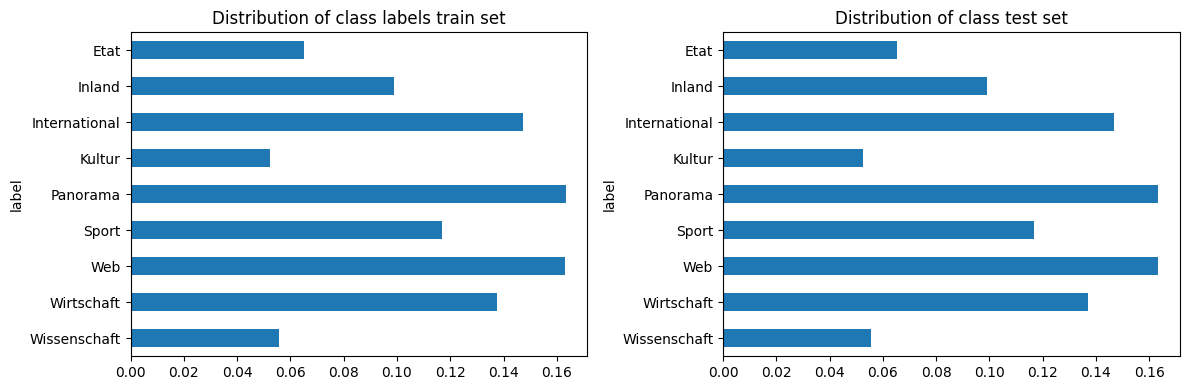

In [4]:
data.plt_label_distribution()

It can be seen that the labels are not uniformly distributed within the dataset. This is an issue that must be addressed during the training of the models. Additionally, an appropriate evaluation metric for the models needs to be chosen. E.g. the F1 score would be a good choice for imbalanced data.

It can also be seen that the distribution of labels in both the test and train splits is about the same, which is positive indication. I will thus keep this split. The ratio of 1/9 (see above) also seems to be reasonable.
<br>
<br>

### 2.2 Distribution of text lengths

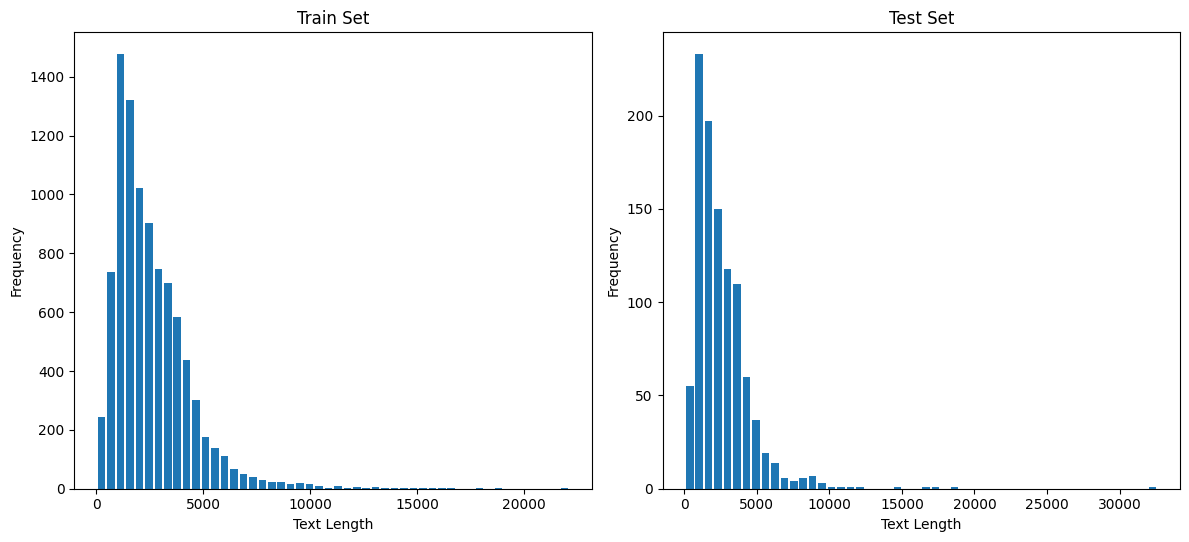

In [5]:
data.plt_text_len_dist()

The avarage article has around 1000 characters and there are are few articles with more than 10'000 characters in the dataset.

# 3. Preprocessing
Let's preprocess the text first by using the following steps:
- text cleaning
- tokenization
- compound word splitting
- stemming
- stop word removal

In [6]:
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

stopwords = set(stopwords.words("german"))

# analyze and revise stopwords
stopwords.add("sehr")
stopwords.add("viel")
stopwords.add("nächst")
stopwords.add("leider")

# remove stop words
#stopwords.remove("nicht")
#stopwords.remove("kein")

[nltk_data] Error loading punkt: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>
[nltk_data] Error loading stopwords: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>


Let's have a look on an example how the preprocessed text looks like:

In [7]:
print("Original Text:")
print(data_all['text_original'].iloc[0])
print();
print("Preprocessed Text:")
print(*preprocess(data_all['text_original'].iloc[0], stopwords=stopwords, do_compound_word_split=True))

Original Text:
21-Jähriger fällt wohl bis Saisonende aus. Wien – Rapid muss wohl bis Saisonende auf Offensivspieler Thomas Murg verzichten. Der im Winter aus Ried gekommene 21-Jährige erlitt beim 0:4-Heimdebakel gegen Admira Wacker Mödling am Samstag einen Teilriss des Innenbandes im linken Knie, wie eine Magnetresonanz-Untersuchung am Donnerstag ergab. Murg erhielt eine Schiene, muss aber nicht operiert werden. Dennoch steht ihm eine mehrwöchige Pause bevor.

Preprocessed Text:
jahrig fallt wohl saison end wien rapid wohl saison end offensivspiel thomas murg verzicht wint ried gekomm jahrig erlitt beim heim debakel admira wack modling samstag teil riss inn band link knie magnet resonanz untersuch donnerstag ergab murg erhielt schien operiert dennoch steht mehrwoch paus bevor


# 4. Build a first base model
In this section I will build a first base model. I have integrated the preprocessing steps into a pipeline along with the Stochastic Gradient Descent (SGD) classifier. The loss parameter is set to 'hinge', which facilitates the creation of a linear Support Vector Machines (SVM) model. Additionally, I have configured the class_weight to 'balanced' to effectively address the issue of an imbalanced dataset."

In [8]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from fhnw.nlp.utils.preprocess import preprocess

def analyze(text:str) -> list:
    """Preprocesses the text (tokenization, stop word removal, lemmantization/stemming and do_compound_word_split)
    Parameters
    ----------
    text : str
        The text to preprocess
    Returns
    -------
    list
        The preprocessed and tokenized text
    """
    return preprocess(text, stopwords=stopwords, do_compound_word_split=True)

pipe = Pipeline([
    #tokenization and stop words are handled within the preprocessing
    ("vec", TfidfVectorizer(ngram_range=(1, 2), tokenizer=lambda x: x, preprocessor=analyze, stop_words=None)),
    ("clf", SGDClassifier(class_weight="balanced"))
])

pipe.fit(X_train, y_train)

/home/claudio/Documents/DAS/NLP/project/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 1min 21s, sys: 6.16 s, total: 1min 28s
Wall time: 2min 15s


Pipeline(steps=[('vec',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 preprocessor=<function analyze at 0x7fb7c5f0b1f0>,
                                 tokenizer=<function <lambda> at 0x7fb7c5f0b310>)),
                ('clf', SGDClassifier(class_weight='balanced'))])

Next I will do the predictions on the training set as well as on the test set:

In [9]:
%%time
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

CPU times: user 1min 19s, sys: 13.1 ms, total: 1min 19s
Wall time: 2min 47s


# 5. Evaluate the model
In a next step we check the metrics:

Train:
               precision    recall  f1-score   support

         Etat       0.99      1.00      1.00       601
       Inland       1.00      1.00      1.00       913
International       1.00      0.99      0.99      1360
       Kultur       1.00      1.00      1.00       485
     Panorama       1.00      0.99      1.00      1510
        Sport       1.00      1.00      1.00      1081
          Web       1.00      1.00      1.00      1509
   Wirtschaft       0.99      1.00      0.99      1270
 Wissenschaft       0.99      1.00      1.00       516

     accuracy                           1.00      9245
    macro avg       1.00      1.00      1.00      9245
 weighted avg       1.00      1.00      1.00      9245

Test:
               precision    recall  f1-score   support

         Etat       0.95      0.81      0.87        67
       Inland       0.84      0.86      0.85       102
International       0.87      0.82      0.85       151
       Kultur       0.84      0.94      0.89    

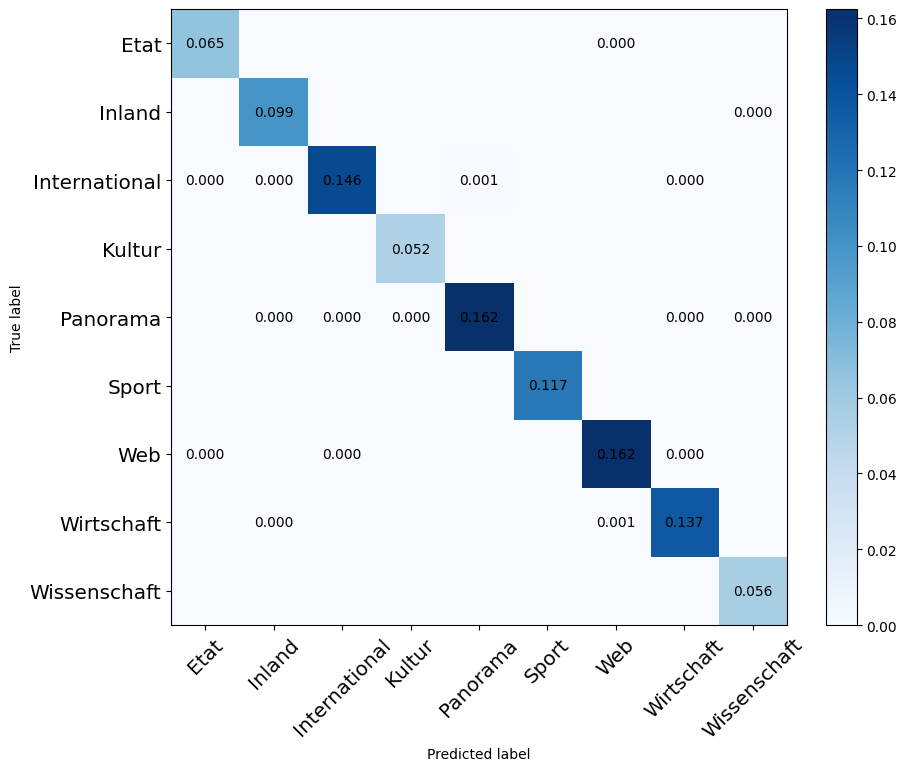

Set Population: 1028
Accuracy: 0.8784


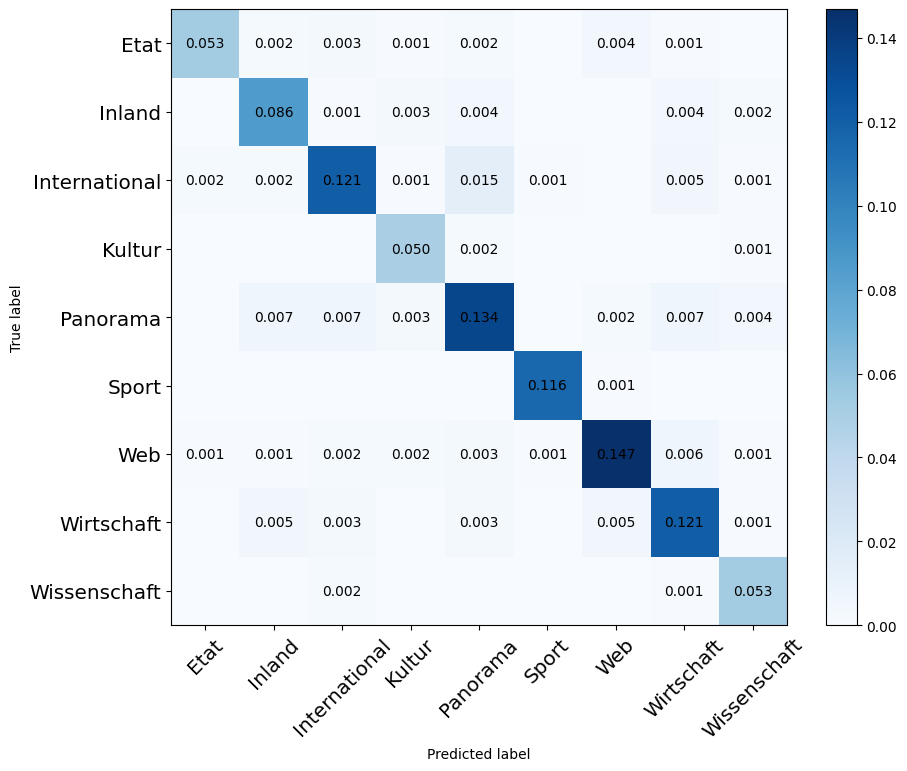

In [10]:
from fhnw.nlp.utils.ploting import plot_confusion_matrix
report = classification_report(y_train, y_train_pred)
print("Train:")
print(report)
report = classification_report(y_test, y_test_pred)
print("Test:")
print(report)

plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_test_pred)

The model shows strong performance, but the discrepancy between training and test results suggests room for improvement, particularly in addressing potential overfitting.

# 6. Interpretaion of first base model

Next, I assess the feature importance to understand whether the class assignments in my model are based on reasonable words. This evaluation is feasible because the SGDClassifier, by default, utilizes a LinearSVC. It's important to remember that a linear SVM operates by creating a hyperplane. This hyperplane, formed with the aid of support vectors, is designed to maximize the distance between the different classes.

The key aspect here lies in the weights derived from svm.coef_. These weights essentially represent the vector coordinates that are orthogonal to the hyperplane. The direction of these vectors is indicative of the predicted class. By analyzing the absolute sizes of these coefficients in comparison to one another, I can effectively gauge the importance of different features.

For a more in-depth understanding of this concept, I'll also be referring to an informative article: "Visualising Top Features in Linear SVM with Scikit-Learn and Matplotlib" on Medium by Aneesha (https://aneesha.medium.com/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d). This article should provide further insights and visualization techniques that can aid in my analysis.

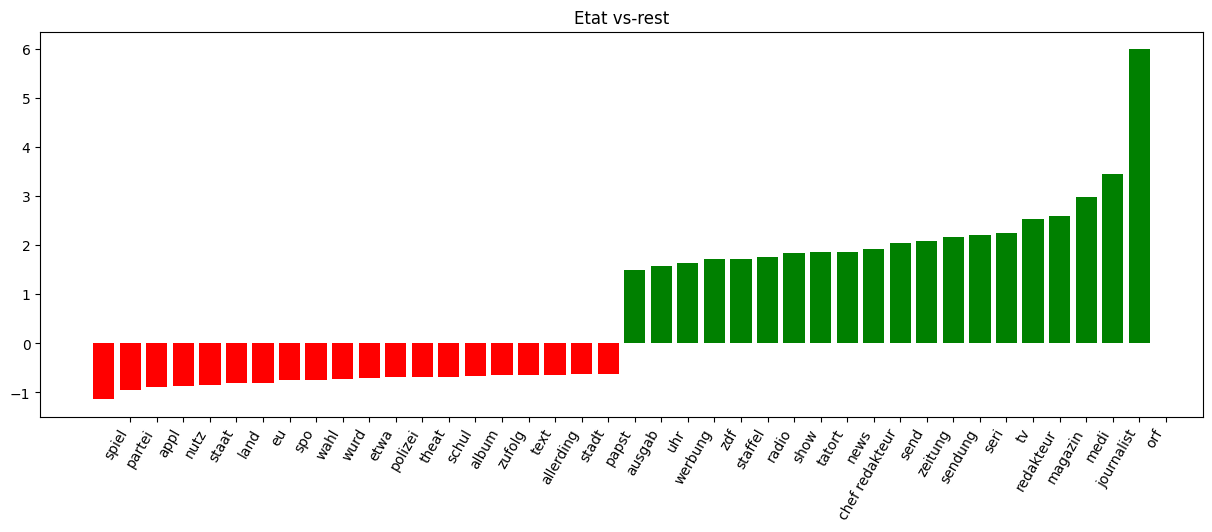

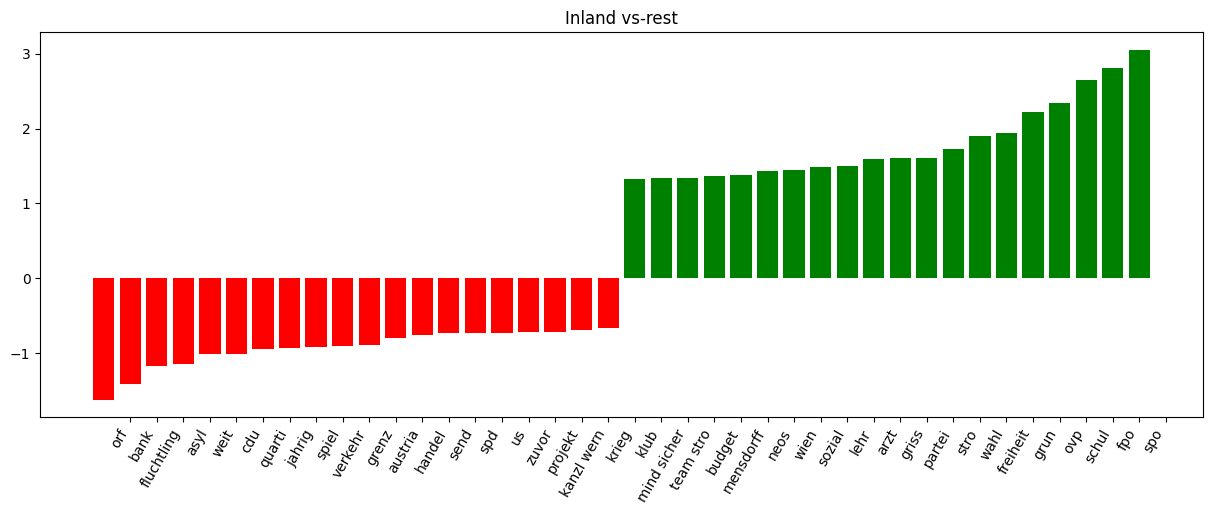

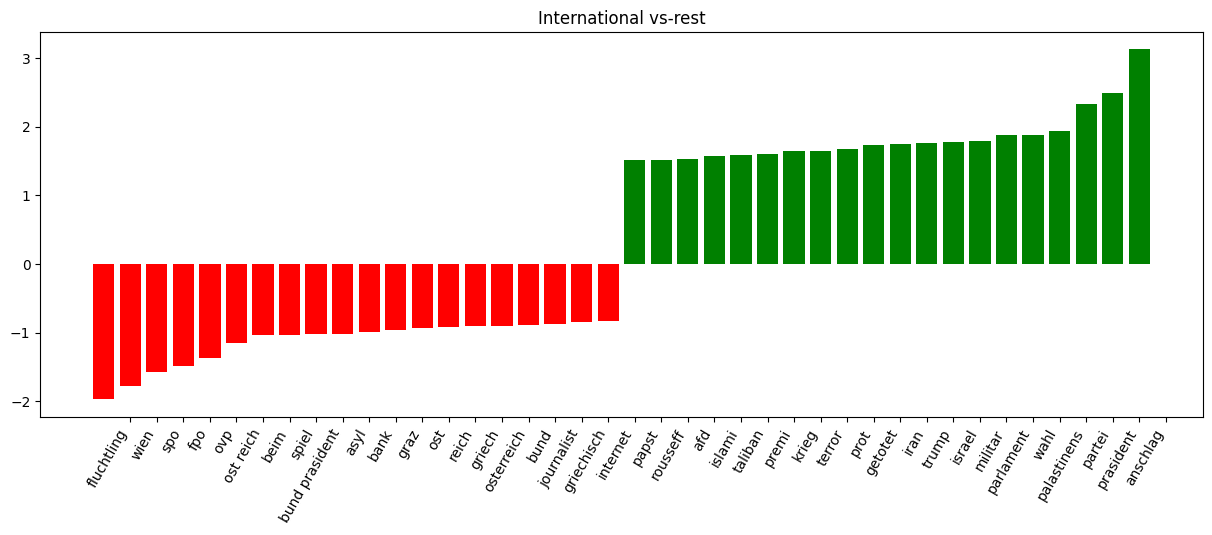

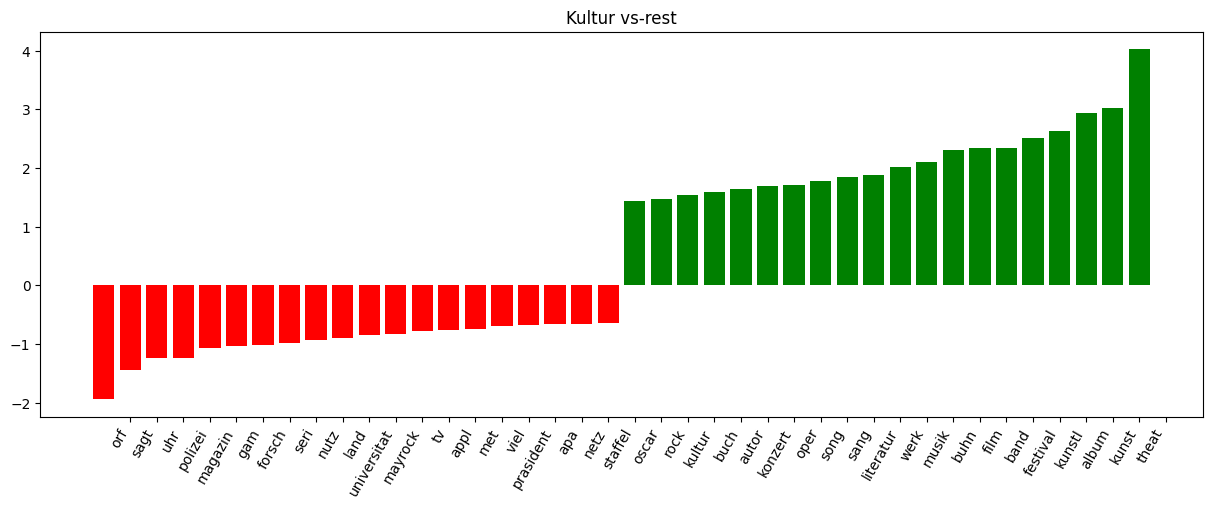

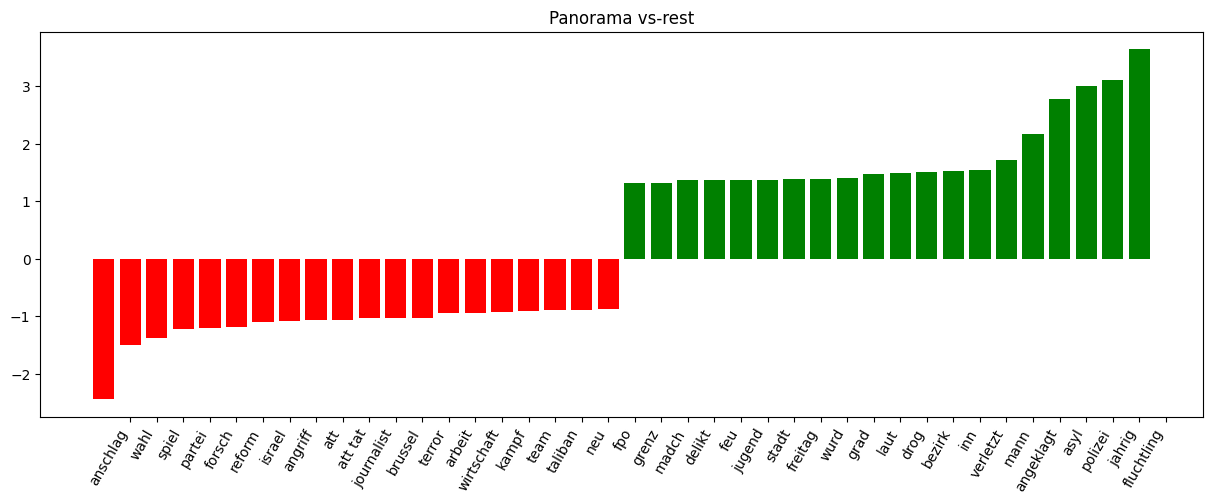

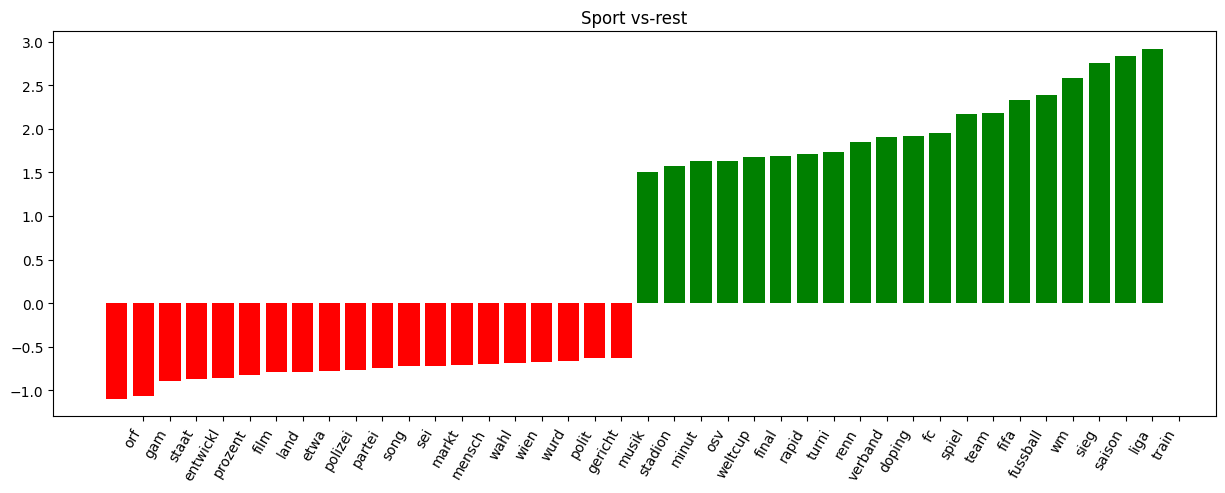

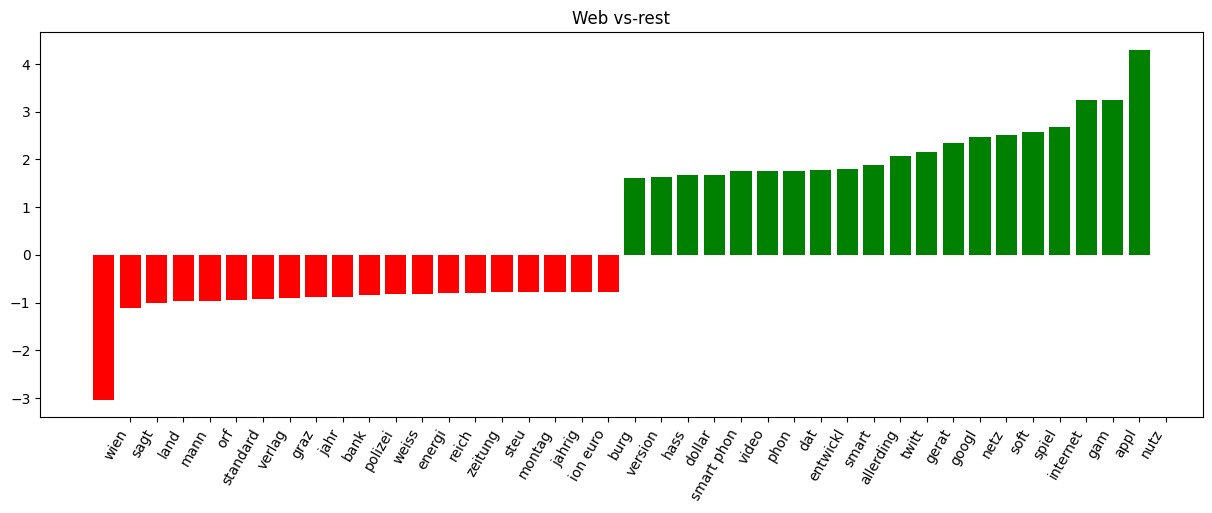

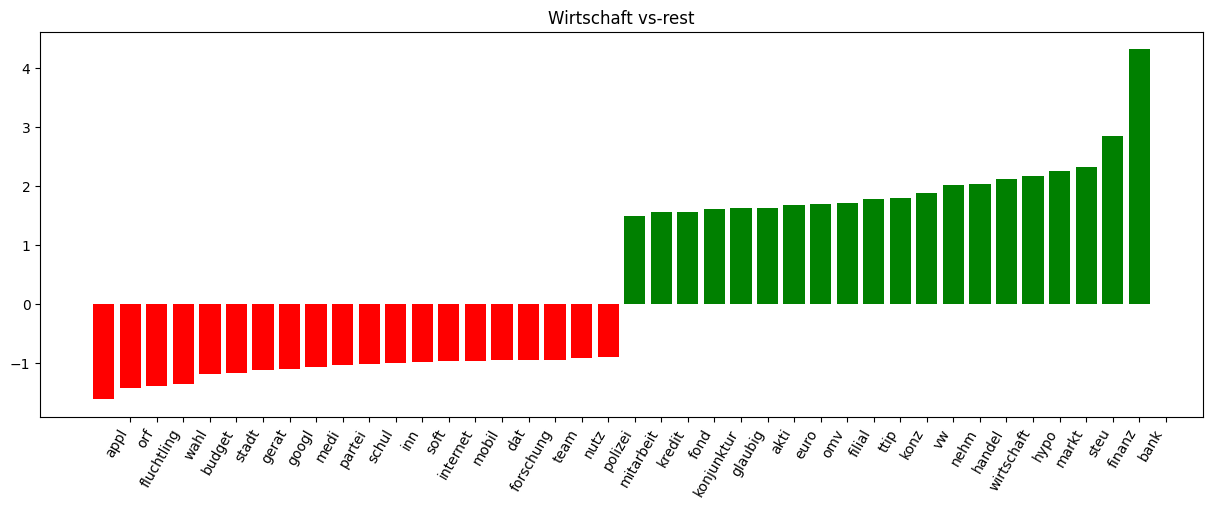

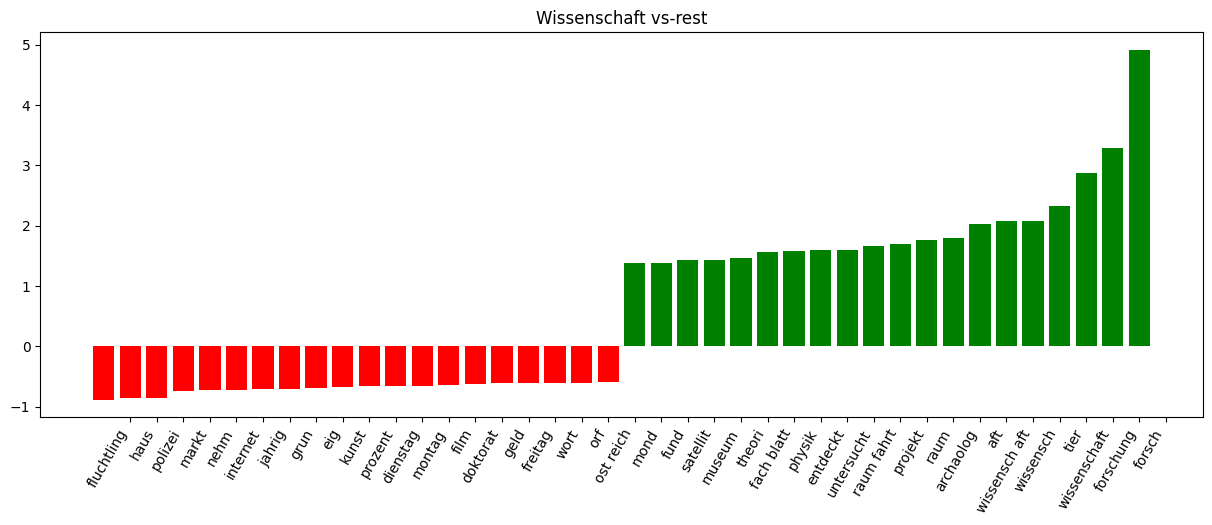

In [11]:
from fhnw.nlp.utils.ploting import plot_feature_importance
vectorizer = pipe.named_steps["vec"]
# only works since SGDClassifier uses LinearSVC by default
classifier = pipe.named_steps["clf"]
plot_feature_importance(classifier, vectorizer.get_feature_names_out())

The analysis of feature importances yields results that are logical and coherent. For instance, the parties 'OVP', 'FPO', and 'SPO' have been classified with a positive correlation to the 'Inland' class. Another example is the tokens 'festival', 'kunst', 'theat', and 'musik', which demonstrate a positive association with the 'Kultur' category. Conversely, terms such as 'polizei' and 'netz' are negatively related. Overall, these findings indicate that the model is of high quality and its classifications are substantiated.

Now lets get an impression on texts with wrong prediction.

In [12]:
pd.set_option('display.max_colwidth', None)
data_train["prediction"] = y_train_pred
data_train[data_train["label"] != data_train["prediction"]][["text_original", "label", "prediction"]].iloc[0:3]

text_original  \
209                                                                                                                                                                                                                                         Beim Thema Geschlechtergerechtigkeit sieht die FPÖ rot. In dem von Norbert Hofer redigierten Blauen-Handbuch wird da als Feindbild gar Lenin bemüht. Über Österreich liegt Spannung. Der neue Bundespräsident wird gewählt. Alexander Van der Bellen oder Norbert Hofer?: Wieder eine Kür, bei der es, wie inzwischen bei fast allen  Wahlen, um die Rolle der FPÖ geht. Denn Hofer hat sich in diesem Wahlkampf immer offen als Kandidat dieser Partei deklariert. Die politischen Inhalte die FPÖ waren daher in den vergangenen Tagen und Wochen naturgemäß ein in der Berichterstattung wichtiges Thema. Auch hier in diesem Blog. Hier ging es etwa um die – laut FPÖ-Parteiprogramm und dem Handbuch freiheitlicher Politik – von der FPÖ gewünschte  Aufwertung des Deutschtums als Grundlage von Kultur und Kunst. Und es ging um die von Hofers Partei angestrebte Wiederabschaffung der zivilen Rechte von Lesben und Schwulen, die diesen in den vergangenen Jahren in Österreich zuerkannt wurden. Massive Änderungen, die auf Verschlechterungen hinauslaufen, sollen laut FPÖ-Plänen aber auch einer weit größeren Bevölkerungsgruppe ins Haus sehen: den Frauen. Laut blauem Parteiprogramm und Handbuch soll es einen Kahlschlag bei allen Maßnahmen geben, mit denen die öffentliche Hand Frauen fördert – etwa um ihre berufliche und einkommensmäßige Situation zu verbessern. Im FPÖ-Parteiprogramm wird dies mit der gleichen – offenbar entwaffnend gemeinten – Offenheit kundgetan, der sich im Bundespräsidentschaftswahlkampf FPÖ-Kandidat Hofer befleißigte: etwa als er ankündigte, man werde sich noch wundern: Die Bevorzugung eines Geschlechts zur Beseitigung tatsächlicher oder vermeintlicher Benachteiligungen wird von uns entschieden abgelehnt, ist da zu lesen. Keine Beseitigung von Benachteiligungen, auch von tatsächlichen nicht: Wie soll man das anders verstehen, als dass die FPÖ – diese laut Demoskopen von besonders vielen Männern gewählte Partei – für die Aufrechterhaltung der auch in Österreich noch ganz realen Ungleichbehandlung von Frauen eintritt? Und, weiter: Daher sprechen wir uns gegen eine Quotenregelung oder das ‚Gender-Mainstreaming‘ aus. Tatsächlich ist das Gender Mainstreaming ein Objekt besonderer Ablehnung der FPÖ. Das unter anderem von der EU befürwortete Prinzip, dass bei Entscheidungen auf allen gesellschaftlichen Ebenen die Gleichstellung der Geschlechter gefördert werden soll, wird von der dieser Partei geradezu verteufelt. Das zeigt sich im – von Norbert Hofer redigierten – Handbuch freiheitlicher Politik in Gestalt eines in der heutigen Zeit völlig deplatzierten Bolschewistenhasses: ‘Gender Mainstreaming‘ soll im ‚Top-Down-Prinzip‘ durchgepeitscht werden. Das bedeutet, dass auf allen staatlichen und gesellschaftlichen Ebenen alle Entscheidungen einer von der Spitze vorgegebenen Maxime unterworfen werden, steht da. Und weiter: Diese Strategie findet ihren Ursprung im Wesen der marxistisch-leninistischen Kaderpartei, in der die revolutionäre Avantgarde (Lenin) die Struktur für den Klassenkampf – hier den Geschlechterkampf –der unbedarften Masse vorgibt. Diesbezüglich, so das Handbuch, sei Konspiration am Werk, eine hidden agenda, die schlussendlich die Zerstörung der Identitäten zum Ziel habe –gesamtgesellschaftlich, kulturell sowie individuellgeschlechtlich. Von Lenins Revolutionären über frühe Feministinnen bis in die heutigen Brüsseler Bürokratenburgen ziehe sich ein roter Faden. Begrifflich dockt die FPÖ hier an die Identitären-Bewegung an, die sich zuletzt durch gut inszenierte Störaktionen hervorgetan hat. Nur: Ist der Marxismus-Leninismus im Jahr 2016 noch von politischer Relevanz? Genießt er in der heutigen, neoliberal bestimmten Welt, hundert Jahre nach der bolschewistischen Revolution, noch irgendeine 

In my opinion, even the incorrect classifications appear to be reasonable. They are not blatantly erroneous. In fact, I find myself uncertain about which classification is more appropriate: the one provided by the dataset or the one generated by my model.

# 7. Hyperparameter Tuning

The model we currently possess appears to be quite effective. However, to further enhance its quality, we should consider implementing hyperparameter tuning. This approach is particularly aimed at achieving better results on the test set. For simplicity, I plan to utilize the Optuna framework for this process.

Given that hyperparameter tuning requires access to the preprocessed tokens in each iteration, it would be prudent to externalize the preprocessing step. By doing so, we can preprocess once and store the tokens, enabling their reuse for each evaluation of the hyperparameters.

In [13]:
%%time
X_train_pre_processed = parallelize_dataframe(data_train, preprocess, field_read="text_original", field_write="tokens", stopwords=stopwords, do_compound_word_split=True)
X_test_pre_processed = parallelize_dataframe(data_test, preprocess, field_read="text_original", field_write="tokens", stopwords=stopwords, do_compound_word_split=True)
X_train, y_train = X_train_pre_processed["tokens"], X_train_pre_processed["label"]
X_test, y_test = X_test_pre_processed["tokens"], X_test_pre_processed["label"]


CPU times: user 444 ms, sys: 264 ms, total: 707 ms
Wall time: 1min 9s


In [14]:
%%capture
#!pip install optuna
!pip install --pre optuna
import optuna
print(optuna.__version__)

In [15]:
#Identity function, returns the same object as it receives. Serialization in python does not work with lambdas (therefore this function).
pipe = Pipeline([
         ("vec", TfidfVectorizer(tokenizer=identity, preprocessor=identity, stop_words=None)),
         ("clf", SGDClassifier())
        ])

In [16]:
scoring_function = make_scorer(f1_score, average='weighted')
#scoring_function = make_scorer(f1_score, average='macro')
def objective(trial):
    params = {
        "clf__alpha": trial.suggest_float("clf__alpha", 1e-7, 1e-4, log=True),
        #"vec__max_features": trial.suggest_int("vec__max_features", 100, 1000),
        "clf__penalty": trial.suggest_categorical("clf__penalty", ["l1", "l2"]),
        "clf__loss": trial.suggest_categorical("clf__loss", ["hinge", "log_loss", "perceptron"]),
        "vec__ngram_range": trial.suggest_categorical("vec__ngram_range", [(1, 1), (1, 2), (2, 2)]),
        "clf__class_weight": trial.suggest_categorical("clf__class_weight", [None, "balanced"]),
        #"clf__max_iter": trial.suggest_int("clf__max_iter", 100, 1000),
    }

    # set the hyper parameters to try
    pipe.set_params(**params)

    return np.mean(cross_val_score(
        pipe,
        X_train,
        y_train,
        # Stratified K-Folds cross-validator (with 3 splits/folds)
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        n_jobs=-1,
        scoring=scoring_function))

In [17]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
#optuna.logging.set_verbosity(optuna.logging.INFO)

import optuna

study = optuna.create_study(
    direction="maximize",
    #sampler=optuna.samplers.MOTPESampler(),
    #sampler=optuna.samplers.NSGAIISampler(),
    pruner=optuna.pruners.HyperbandPruner(),
)

print(f"Sampler is {study.sampler.__class__.__name__}")
print(f"Pruner is {study.pruner.__class__.__name__}")

Sampler is TPESampler
Pruner is HyperbandPruner


In [ ]:
%%time
study.optimize(
    objective,
    n_trials=100,
)

In [19]:
print(study.best_trial.values)
print(study.best_trial.params)

[0.8645466633944144]
{'clf__alpha': 4.7868398204386704e-05, 'clf__penalty': 'l2', 'clf__loss': 'log_loss', 'vec__ngram_range': (1, 1), 'clf__class_weight': 'balanced'}


Let's gain insights into the hyperparameter optimization process by generating several plots that Optuna offers as built-in features."

In [20]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

*plot_optimization_history(study)*

**Purpose:** This plot shows the scores (like loss or accuracy) for each trial over time.

**Insights:** You can see how the model's performance improves (or not) as the number of trials increases. It helps in understanding if the optimization process is converging and how quickly.

<b style="color:red;">Note: If you cant see any plots, open the notebook in Google Collab!</b>

In [21]:
plot_optimization_history(study)

*plot_parallel_coordinate(study)*

**Purpose:** It displays a parallel coordinates plot which visualizes high-dimensional parameter relationships.

**Insights:** You can observe how different parameter combinations affect the performance. It's useful for identifying trends and patterns across multiple parameters simultaneously.

In [22]:
plot_parallel_coordinate(study)

*plot_contour(study)*

**Purpose:** This creates a contour plot to visualize the relationship between two or three hyperparameters.

**Insights:** It helps in understanding the interaction between parameters and can identify areas where the objective function (like accuracy or loss) is optimized. It's beneficial for pinpointing optimal parameter ranges.

In [23]:
plot_contour(study)

*plot_slice(study)*

**Purpose:** Slice plots show the relationship between a single hyperparameter and the objective function.

**Insights:** You can see how variations in a single parameter affect model performance. It's great for identifying optimal values and ranges for individual parameters.

In [24]:
plot_slice(study)

*plot_param_importances(study)*

**Purpose:** This plot ranks the importance of each hyperparameter in terms of their impact on the model's performance.

**Insights:** It highlights which parameters are most influential, guiding you on where to focus for further tuning or simplifying the model by removing less critical parameters.

In [25]:
plot_param_importances(study)

Now, I will construct a final model utilizing the optimal parameters identified through hyperparameter tuning and evaluate its performance metrics.

In [26]:
pipe.set_params(**study.best_params)
pipe.fit(X_train, y_train)

Pipeline(steps=[('vec',
                 TfidfVectorizer(preprocessor=<function identity at 0x7fb7d6af4b80>,
                                 tokenizer=<function identity at 0x7fb7d6af4b80>)),
                ('clf',
                 SGDClassifier(alpha=4.7868398204386704e-05,
                               class_weight='balanced', loss='log_loss'))])

In [27]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

In [28]:
report = classification_report(y_train, y_train_pred)
print("Train:")
print(report)
report = classification_report(y_test, y_test_pred)
print("Test:")
print(report)

Train:
               precision    recall  f1-score   support

         Etat       0.98      0.98      0.98       601
       Inland       0.94      0.95      0.94       913
International       0.97      0.96      0.97      1360
       Kultur       0.95      0.99      0.97       485
     Panorama       0.95      0.94      0.94      1510
        Sport       0.99      1.00      0.99      1081
          Web       0.98      0.95      0.96      1509
   Wirtschaft       0.93      0.95      0.94      1270
 Wissenschaft       0.97      0.99      0.98       516

     accuracy                           0.96      9245
    macro avg       0.96      0.97      0.96      9245
 weighted avg       0.96      0.96      0.96      9245

Test:
               precision    recall  f1-score   support

         Etat       0.91      0.79      0.85        67
       Inland       0.80      0.79      0.80       102
International       0.87      0.83      0.85       151
       Kultur       0.80      0.98      0.88    

Set Population: 9245
Accuracy: 0.9614


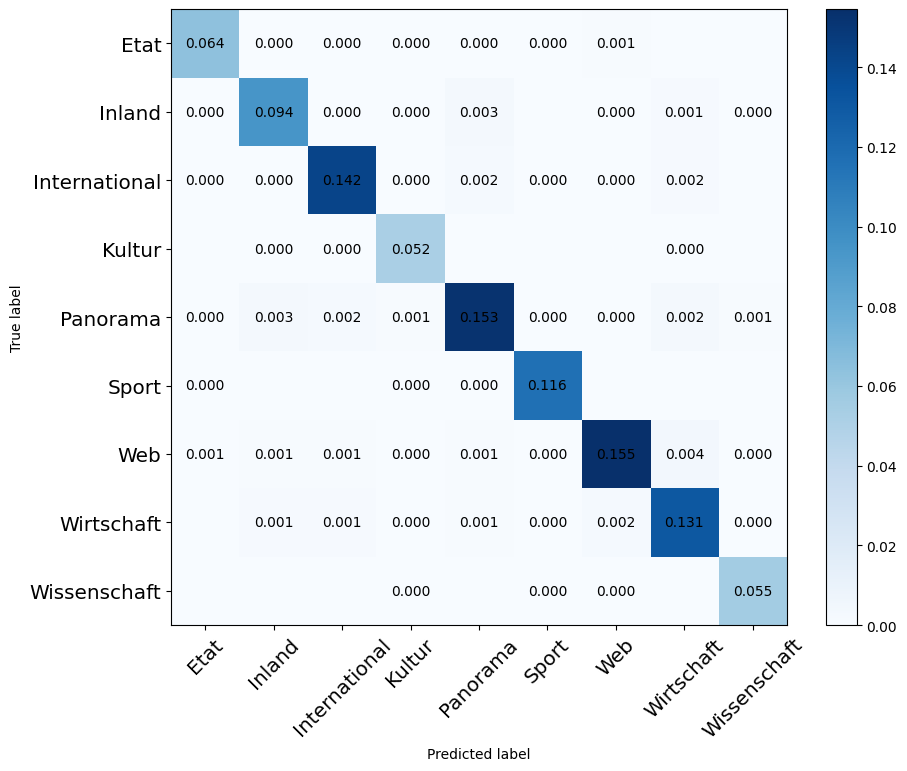

Set Population: 1028
Accuracy: 0.8677


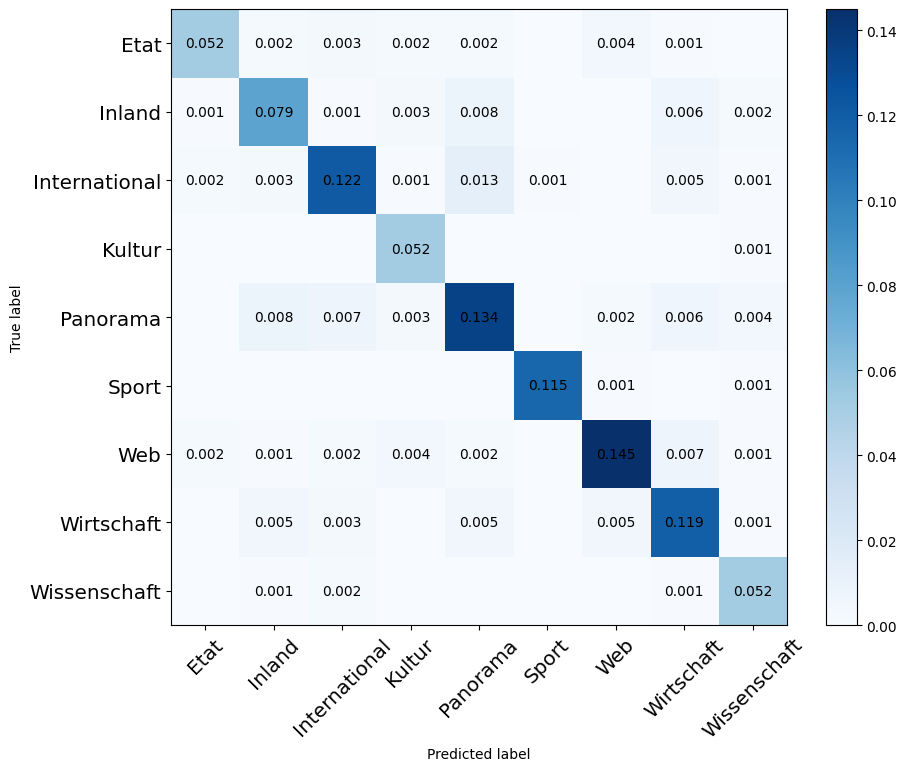

In [29]:
plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_test_pred)

The generated base model, consisting of a TF-IDF vectorizer and a Stochastic Gradient Descent classifier, has yielded surprisingly effective results. The macro F1 score, an average measure well-suited for the imbalanced dataset is 0.87. This score highlights the model's robustness and balanced performance across various classes.

# &#10132; F1 macro avg = 0.87